# Sprawozdanie - Lab 5

* Autor: **Bartosz Mikulski**
* Numer indeksu: **131803**

In [47]:
from sklearn.manifold import MDS, TSNE, Isomap
from sklearn.decomposition import PCA
from sklearn.datasets import make_swiss_roll, make_circles, load_digits
from sklearn.preprocessing import StandardScaler
from umap import UMAP

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import warnings

plt.style.use('seaborn')
warnings.filterwarnings("ignore")

%matplotlib inline

### Definicje pomocnicze

Klasa Transformer jest używana do transformacji wejściowych tabel oraz przechowywania informacji o nazwie transformacji i jej parametrach.

In [15]:
class Transformer:
    def __init__(self, clazz, **params):
        self.params = params
        self.transformer = clazz(**params)
        
    def __repr__(self):
        args = [f"{k}={v}" for k, v in self.params.items()]
        return f"{type(self.transformer).__name__}({', '.join(args)})"
    
    def __call__(self, df):
        data = self.transformer.fit_transform(df.values)
        data_df = pd.DataFrame(data)
        data_df.columns = ['x', 'y']
        data_df.index = df.index
        return data_df

Lista przetestowanych transformacji. Ustawione są w taki sposób, że wiersze zwierają różne algorytmy, a kolumny różne zestawy parametrów. Różnicą jest pierwszy wiersz gdzie używany jest MDS, PCA oraz PCA z wybielaniem.

In [16]:
transformers = [
    Transformer(MDS),
    Transformer(PCA, n_components=2),
    Transformer(PCA, n_components=2, whiten=True),
    
    Transformer(TSNE, perplexity=10), 
    Transformer(TSNE, perplexity=35),
    Transformer(TSNE, perplexity=50),
    
    Transformer(Isomap, n_neighbors=5),
    Transformer(Isomap, n_neighbors=8),
    Transformer(Isomap, n_neighbors=11), 
    
    Transformer(UMAP, n_neighbors=5),
    Transformer(UMAP, n_neighbors=9),
    Transformer(UMAP, n_neighbors=15)
]

In [32]:
def plot_all(plot_f: callable):
    fig, axs = plt.subplots(4, 3, figsize=(20, 16), dpi=100)

    for ax, transformer in zip(axs.ravel(), transformers):
        plot_f(transformer, ax)
    
    fig.tight_layout()

## Zbiór danych cars

Zbiór zawiera nienazwane parametry różnych modeli samochodów.

In [17]:
cars_df = pd.read_csv('cars.csv', header=None, index_col=0)
cars_df.index = cars_df.index.str.strip("''")
cars_df.index.name = 'model'
cars_df

1     2       3   4
model                                    
Alfa Romeo 156      8.1   9.3  71.135   9
Audi A4             7.9  11.9  93.351  10
BMW 316l            7.5  12.3  81.787   8
Daewoo Lanos        8.4  12.2  34.900   3
Honda Civic         6.7  10.8  48.900   7
Hyunday Accent      6.4  11.7  35.300   2
Lada Samara         7.2  13.0  24.900   2
Mitsubishi Carisma  7.2  12.0  60.600   9
Opel Astra II       7.0  12.0  56.950   8
Peugeot 206 XR      6.6  13.2  38.358   4
Renault Megane      7.0   9.9  50.050   9
Saab 9 3S           9.7  11.0  85.352   8
Seat Cordoba        8.3  10.9  44.990   8
Toyota Corrola      7.7  10.2  50.358   4
Volkswagen Golf IV  8.3   9.9  61.622   6

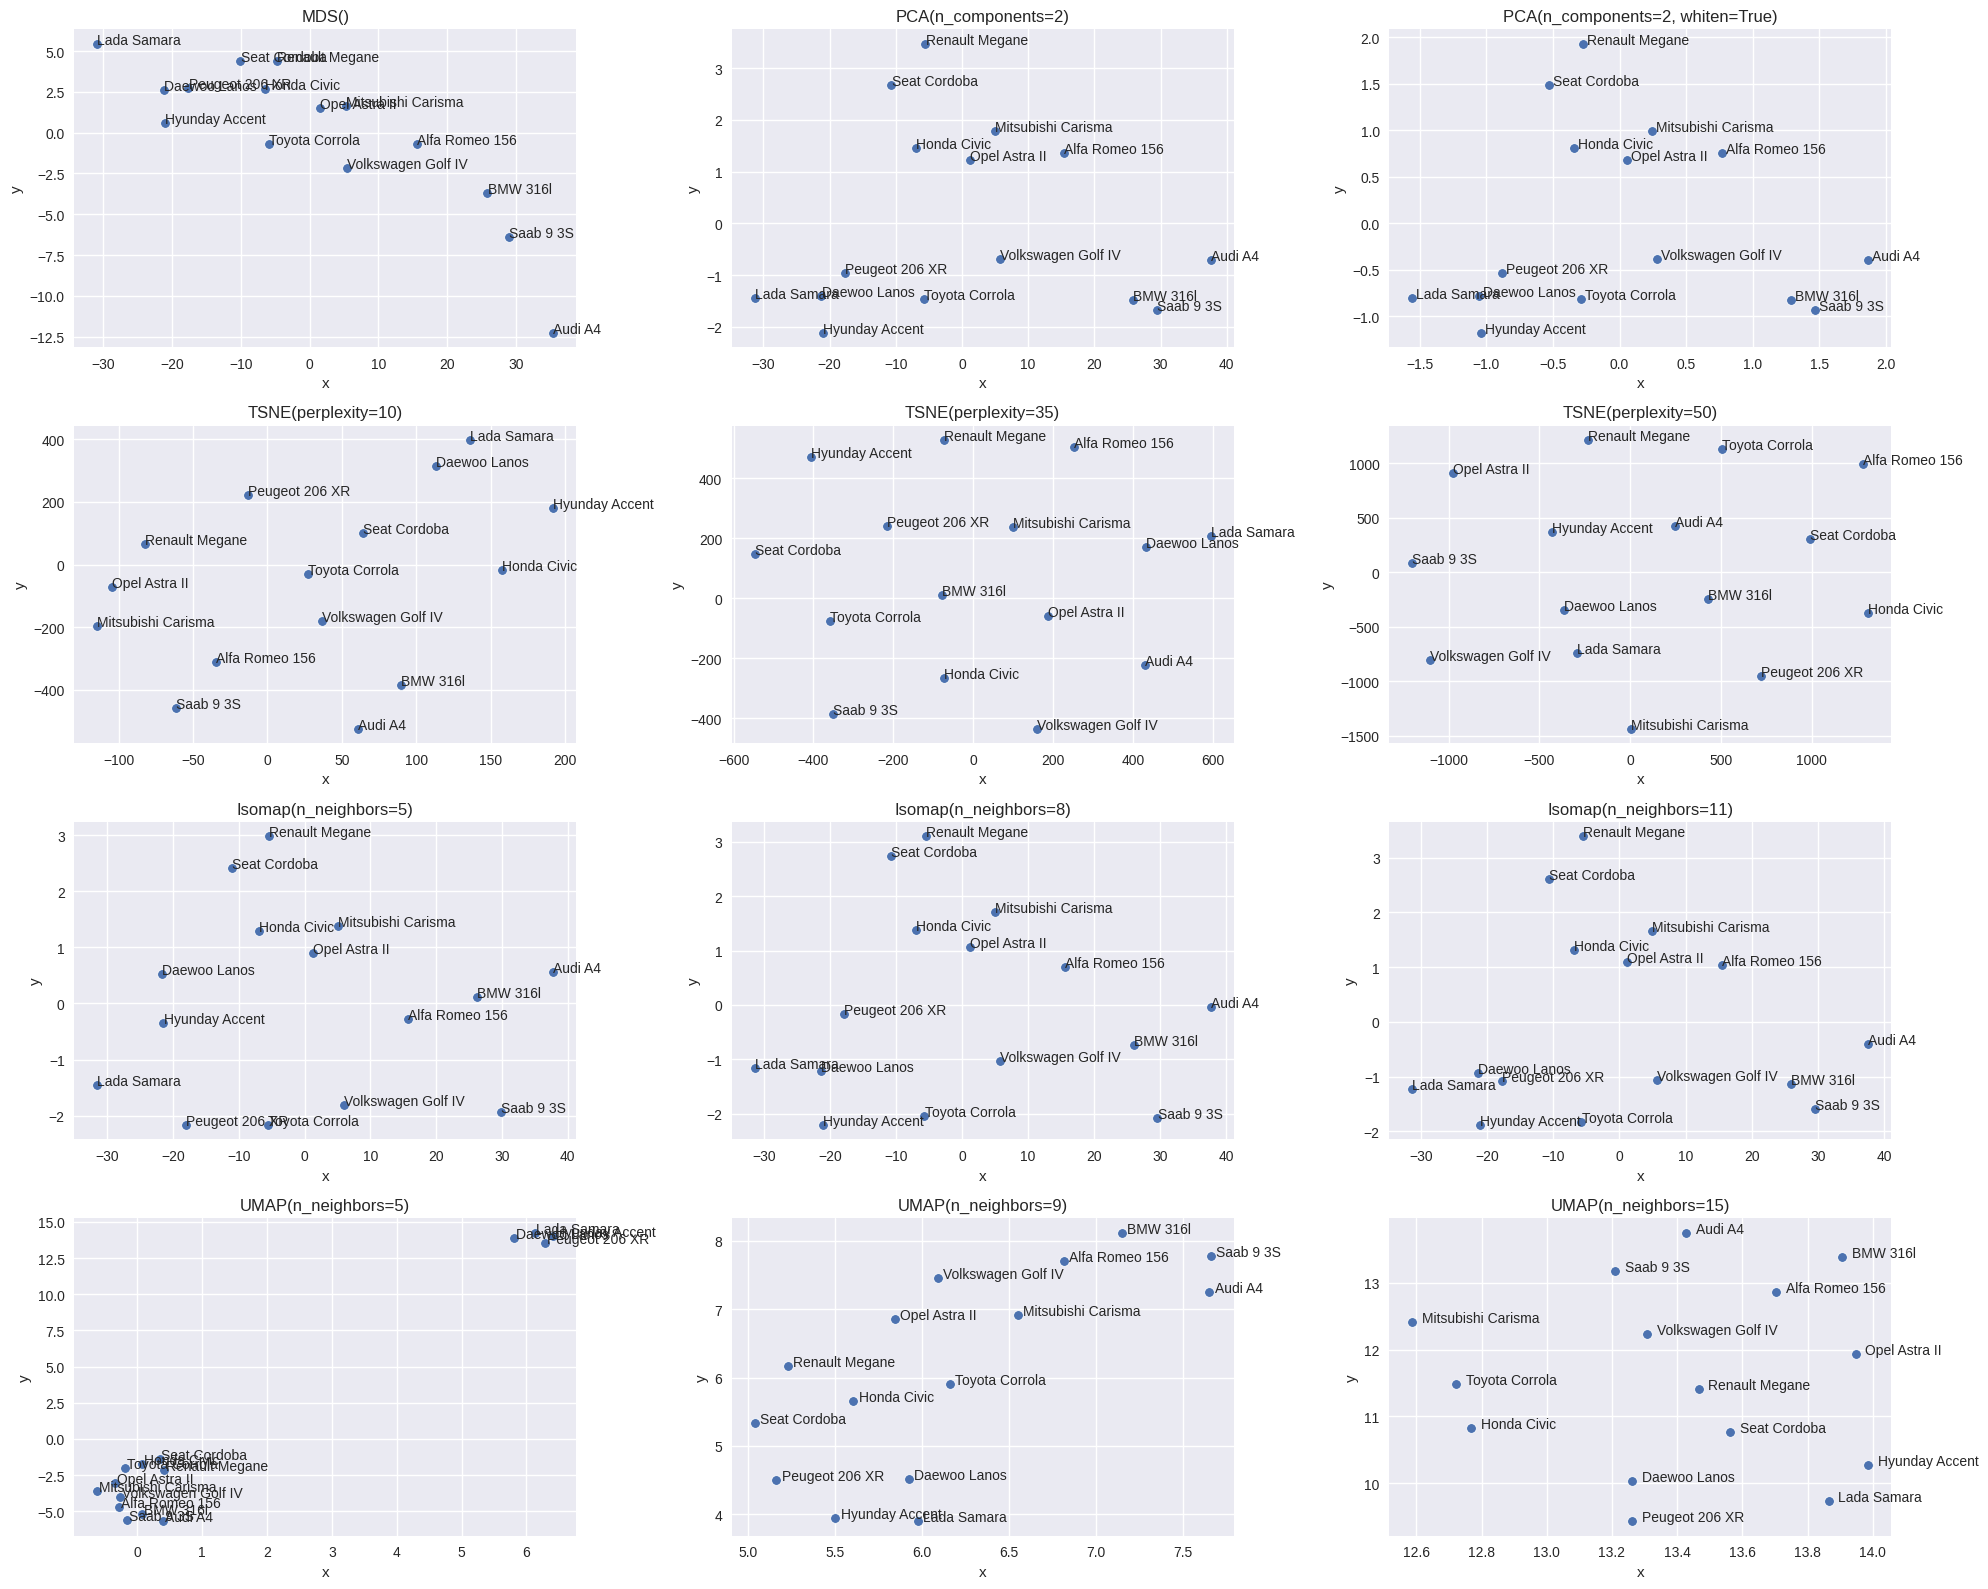

In [33]:
def plot_cars(transformer, ax):
    df = transformer(cars_df)
    sns.scatterplot(data=df, x='x', y='y', ax=ax)
    ax.set(title=str(transformer))
    
    for name, point in df.iterrows():
        ax.text(point['x']+.03, point['y'], name)
        
plot_all(plot_cars)

### Wnioski dla zbioru Cars

**MDS** umiejscowił modele samochodów na pewnej krzywej. Powoduje to, że są one ściśnięte, jednakże takie ułożenie ma sens. Widać, że Audi oraz Łada są po zupełnie przeciwnych stronach. Ciężko jednak zgodzić się z innymi samochodami, ponieważ według mnie VW Golf nie powinien być tak blisko Alfa Romeo.

**PCA** w obu wersjach zachowało się identycznie. Audi, BMW i Saab są blisko, tak samo Łada oraz Lanos są blisko. Jest także znaczącna odległość od tych Audi, a Łady. Można zauważyć dwa zgrupowania - górne, gdzie są Ope, Mitshuishi i Alfa Romeo oraz dolne gdzie są Łada, Lanos, Audi, BWM itp.

**TSNE** bardzo równiemiernie wykorzystało dostępną przestrzeń, co jest na plus. Jednakże wyniki mają sens przy perplexity=10, gdzie Łada jest na górze, a Audi na dole (są od siebie mocno oddalone). Natomiast dla pozostałych wykresów **TSNE** traci sens, bo Łada i Lanos są blisko Audi (porównywalna odległość co Audi i BWM)

**Isomap** uzyskał podobny rozkład jak **PCA**. O ile występują drobne różnice w lokalizacji punktów, to jednak interpretacja jest podobna. Isomapa z 8 sąsiadami jest według mnie najlepsza, ponieważ Łada i Lanos są blisko, a także pozostałe samochody są od nich oddalone w sensowny sposób. Audi oraz Łada dzieli duża odległość.

**UMAP** dla małej liczby sąsiadów (`n_neightbors=5`) przestrzeń została biednie zagospodarowana. Wartości znalazły się w dwóch skupiskach: Łada, Lanos, Hunday oraz Peugeot w jednym, a pozostałe w drugim. Dopiero przy 9 i 15 sąsiadach wykorzystanie przestrzeni jest lepsze, a także podobne samochody są blisko siebie.

## Zbiór danych Swiss Roll

Poniżej znajduje się podgląd na zbiór Swiss Roll w trzech wymiarach.

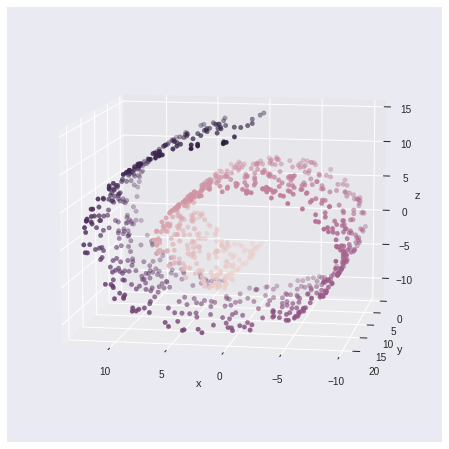

In [69]:
swiss_roll_df, index = make_swiss_roll(1000)
swiss_roll_df = pd.DataFrame(swiss_roll_df, index=index)
swiss_roll_df.columns = ['x', 'y', 'z']

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

ax.scatter(swiss_roll_df.x, swiss_roll_df.y, swiss_roll_df.z, c=swiss_roll_df.index, cmap=sns.cubehelix_palette(as_cmap=True))
ax.view_init(10, 100)

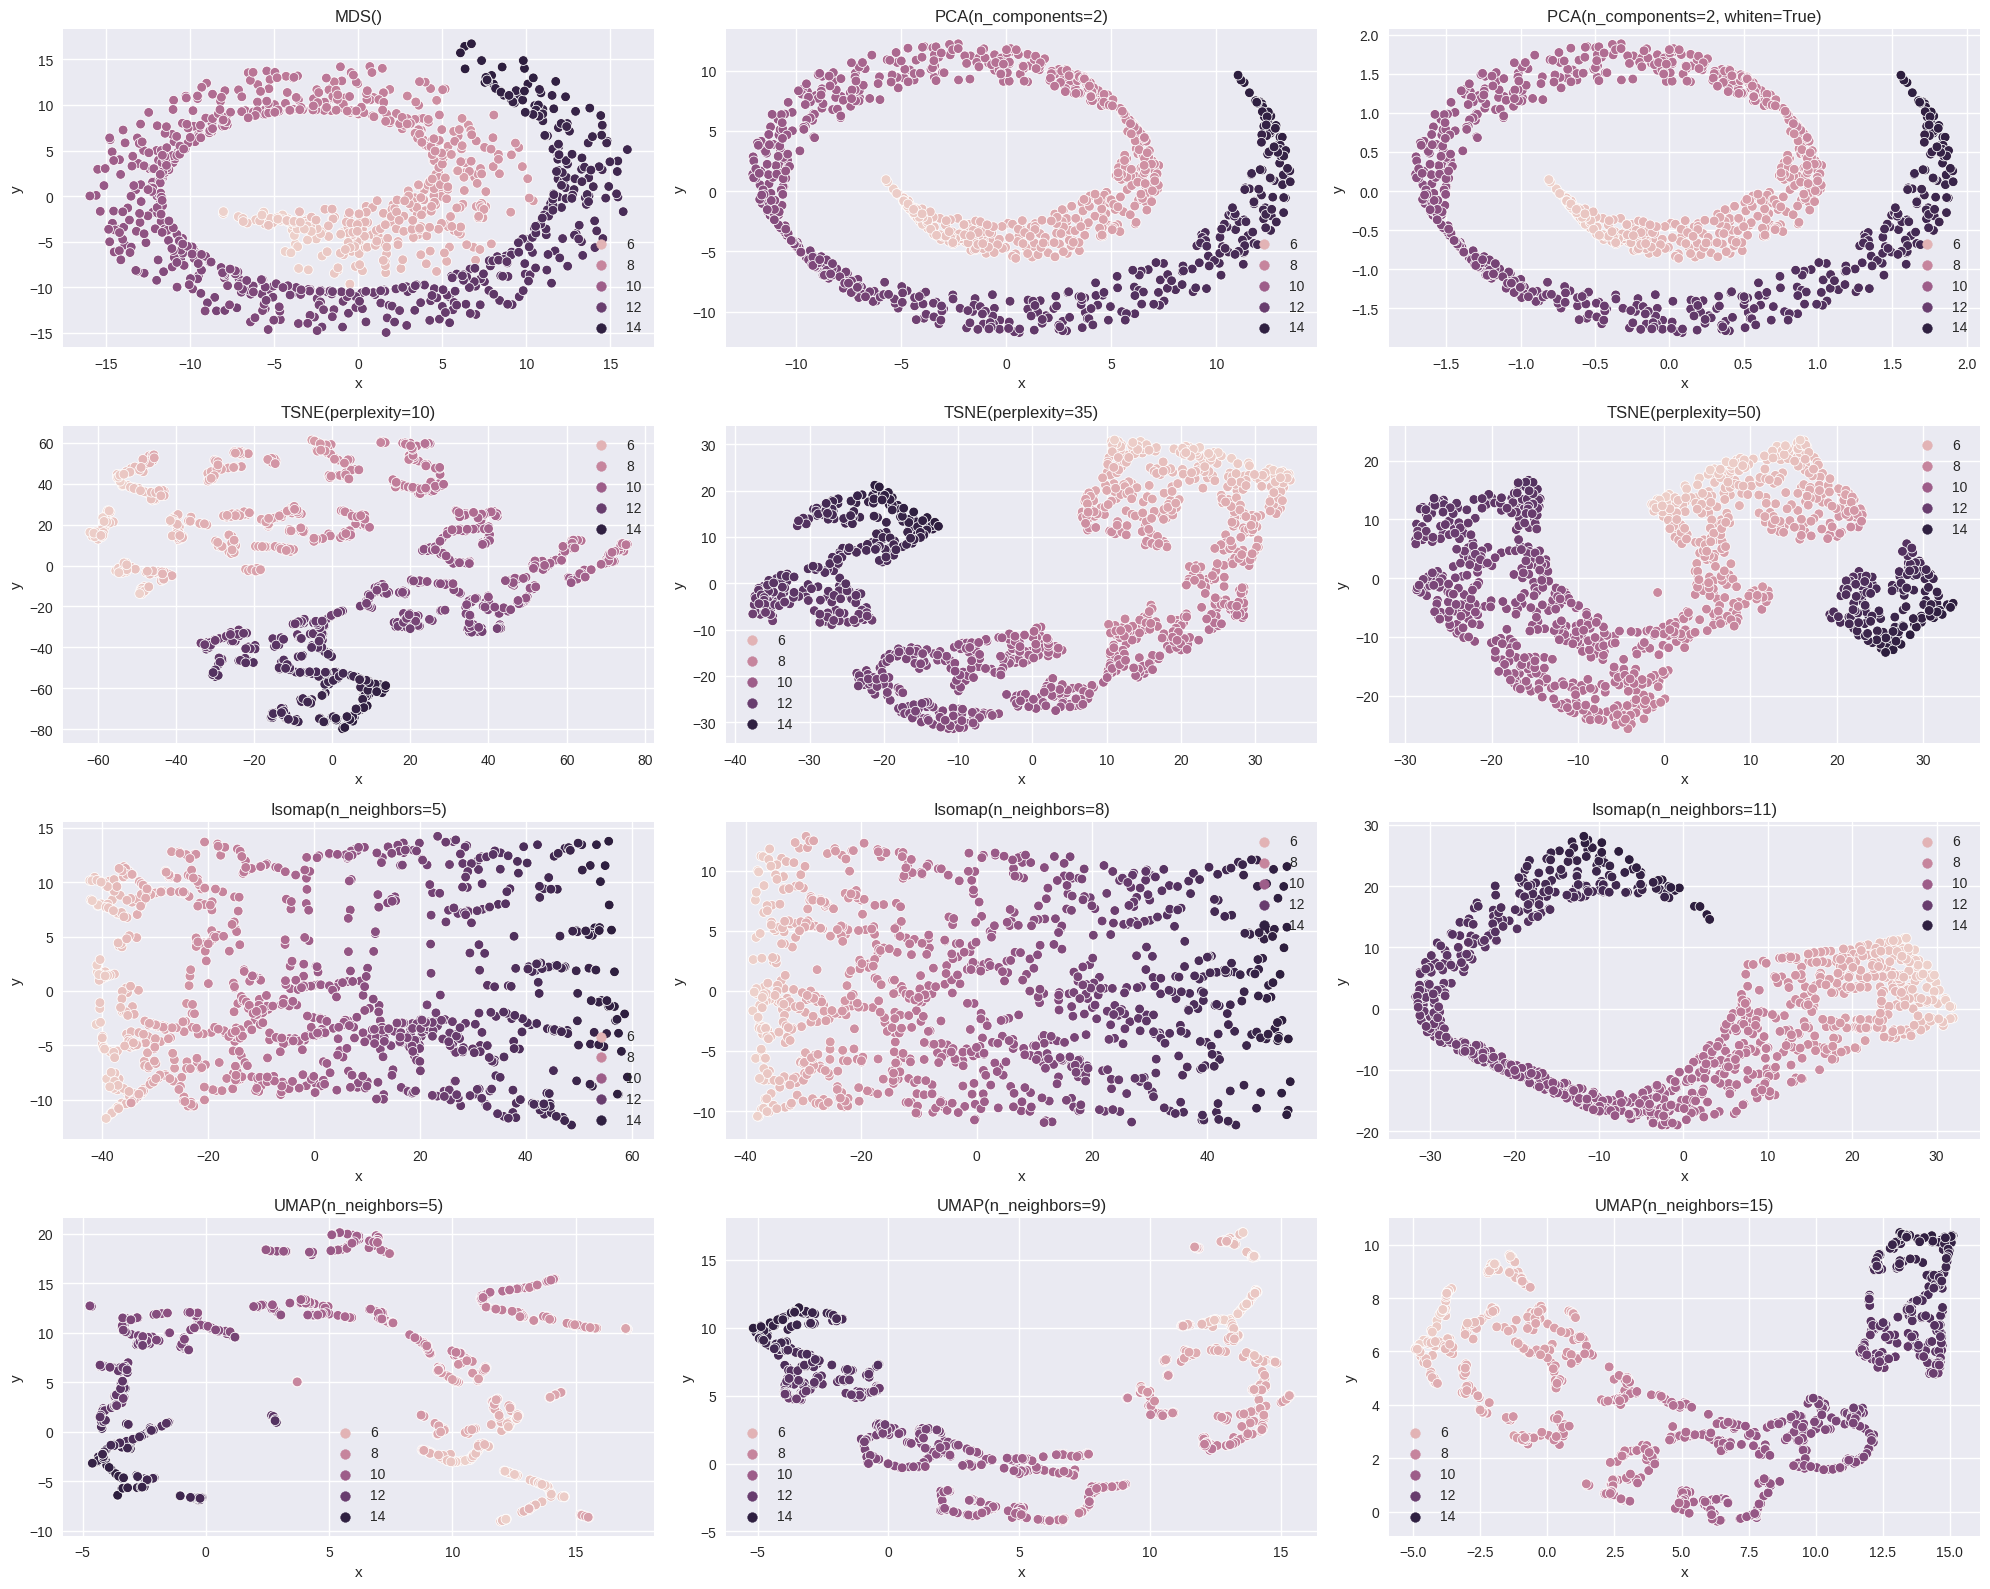

In [37]:
def plot_swiss_roll(transformer, ax):
    df = transformer(swiss_roll_df)
    sns.scatterplot(data=df, x='x', y='y', hue=df.index, ax=ax)
    ax.set(title=str(transformer))
        
plot_all(plot_swiss_roll)

### Wnioski dla zbioru Swiss Roll 

**MDS** oraz **PCA** nie poradziły sobie z wiernym odwzorowaniem danych. Generują spiralę, ale przykłady ciemne i jasne są bardzo blisko siebie, a powinnybyć oddalone. 

**TSNE** poradziło sobie lepiej, ponieważ przy wartości perplexity=35 odpowiadające sobie kolory są sobie blisko, a odmienne kolory są względnie daleko. Jednakże wykorzystanie przestrzeni nie jest najlepsze. TSNE z perplexity=50 trochę przekłamuje zbiór danych ponieważ duża część ciemnych kropek jest oderwana od reszty danych i jest bliżej jasnych kropek.

Najlepiej radzi sobie metoda **Isomap** z liczbą sąsiadów równą 8. Sąsiedzi w Swiss Roll są odpowiednio odwzorowani na przestrzeń 2D. Algorytm wykorzystuje prawie całą dostępną przestrzeń. Dla mniejszej liczby sąsiadów metoda nadal działa dobrze, ale nie jest to aż tak dobry wynik jak przy 8. Przy liczbie sąsiadów równej 11, algorytm zwraca gorsze wynik. Sąsiedzi zgadzają się kolorystycznie, jednakże całą bryła zakręca i ciemne punkty są bardzo blisko jasnych.

**UMAP** ma średnie wyniki. Dopiero przy liczbie sąsiadów równej 15 widać pewną ciągłość w obserwowanych danych, a odległości też mają sens. Jednakże dla mniejszej liczby sąsiadów odwzorowanie jest zdecydowanie gorsze.

## Zbiór danych digits

Zbiór danych zawierający obrazy ręcznie pisanych cyfr od 0 do 10 o rozdzielczości 16x16 pikseli.

In [62]:
digits_df, index = load_digits(return_X_y=True, as_frame=True)
index = index.astype(str)
digits_df.set_index(index, inplace=True)
digits_df = digits_df / 16.0

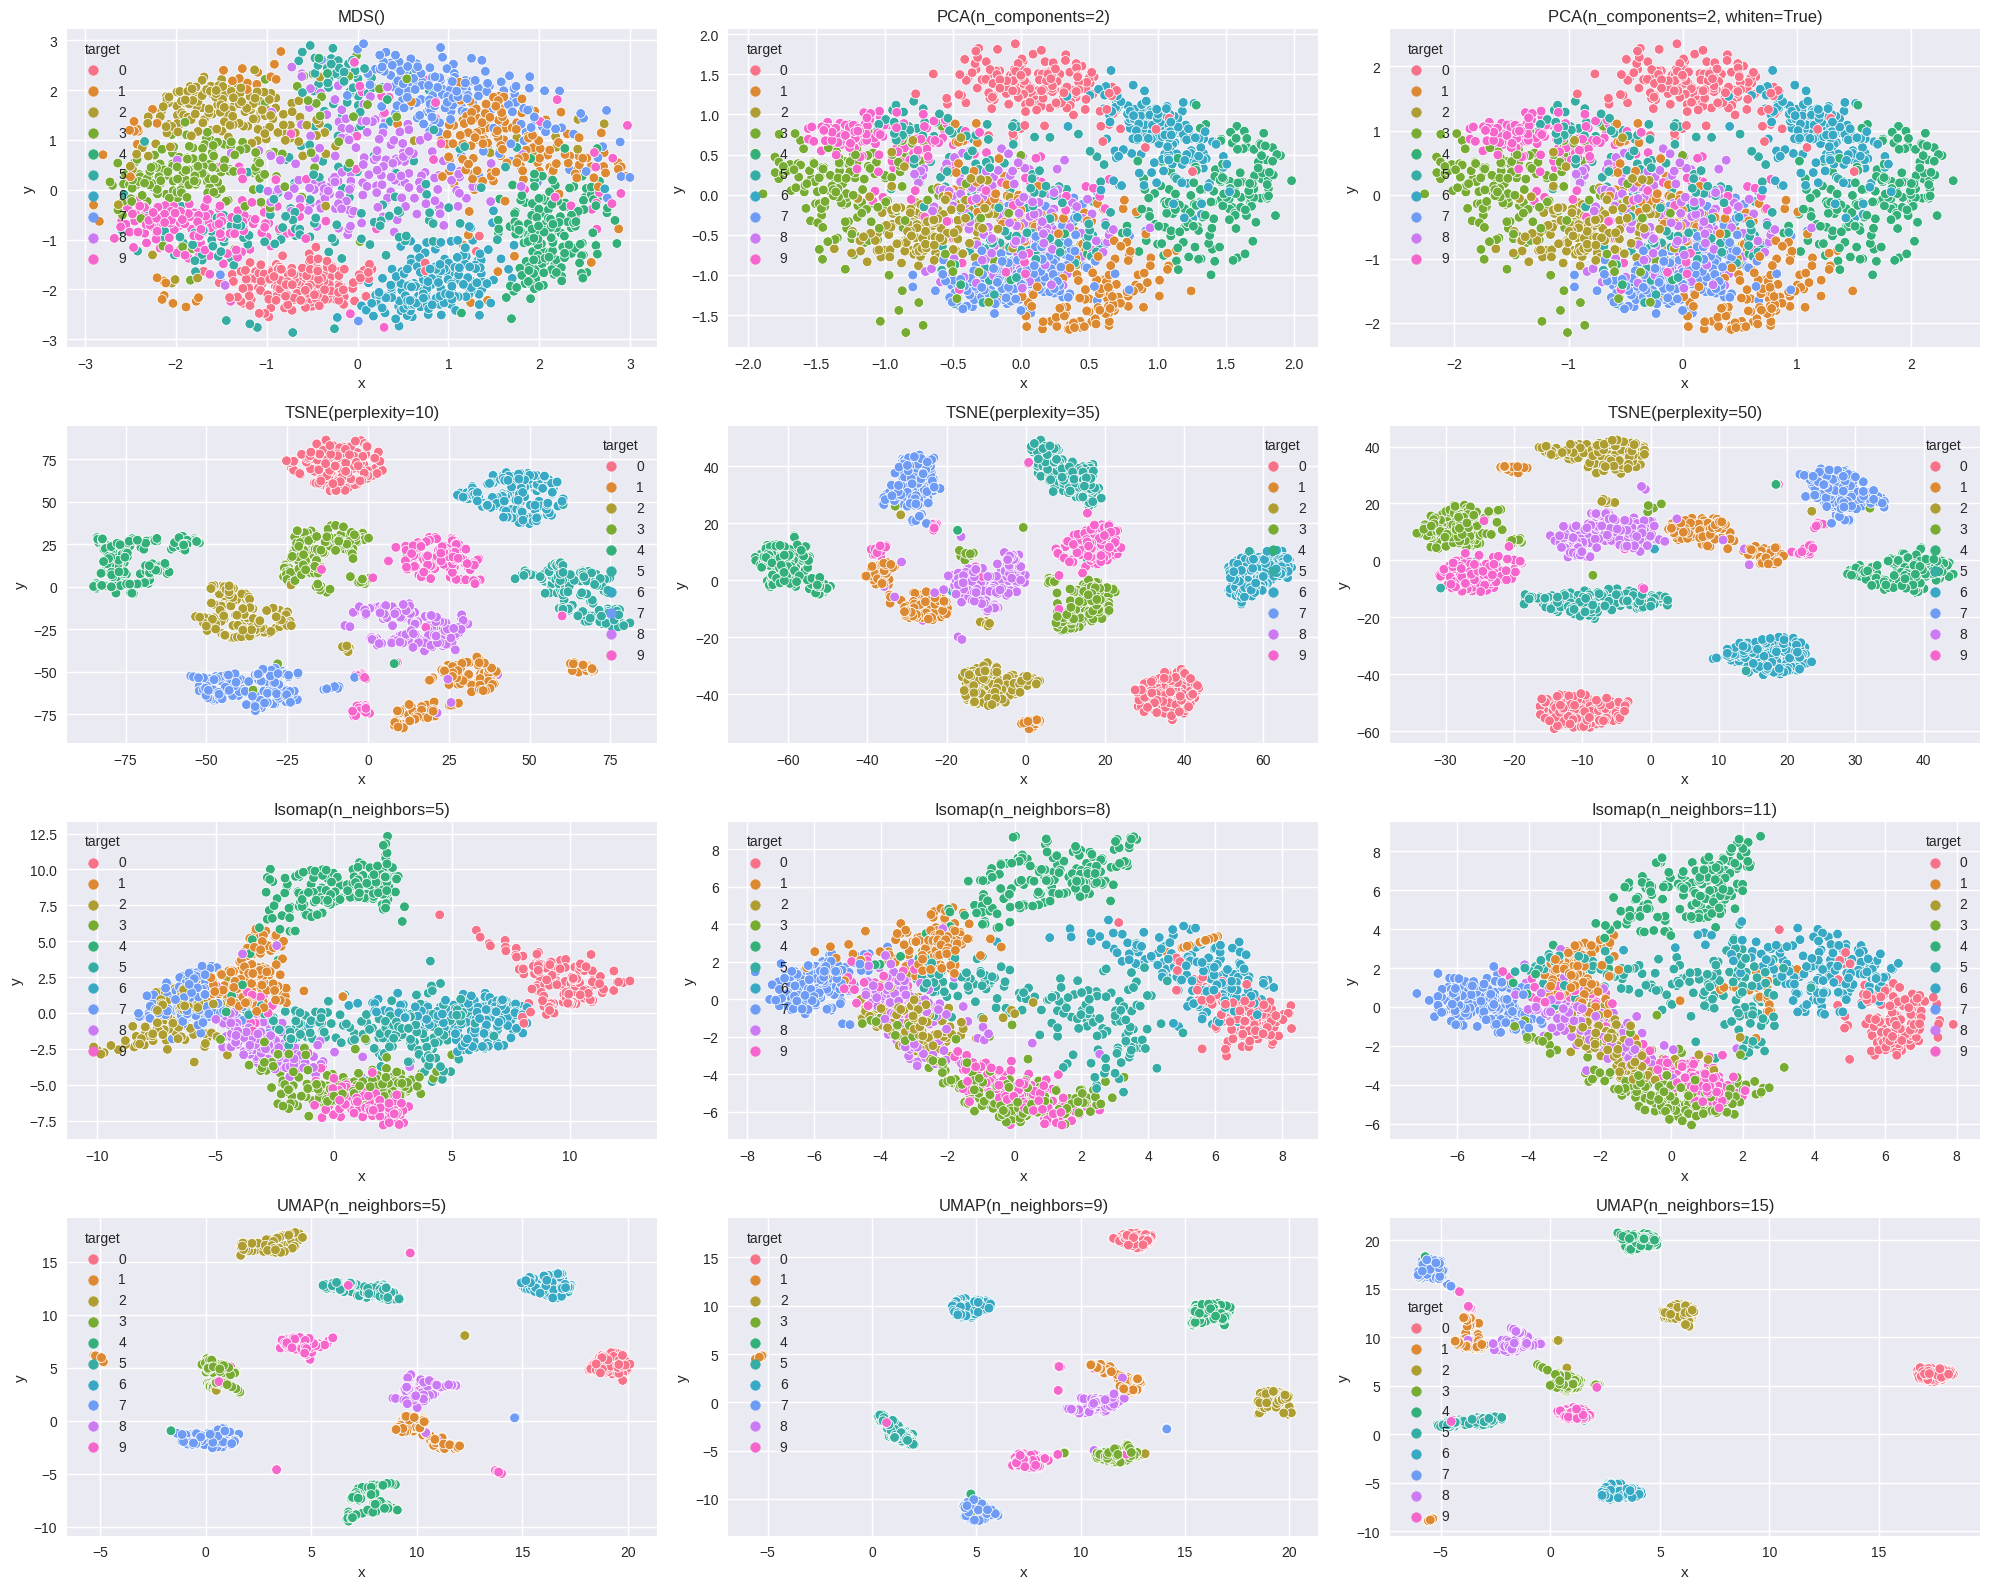

In [63]:
def plot_digits(transformer, ax):
    df = transformer(digits_df)
    sns.scatterplot(data=df, x='x', y='y', hue=df.index, ax=ax)
    ax.set(title=str(transformer))
        
plot_all(plot_digits)

### Wnioski dla zbioru digits

**MDS** oraz **PCA** generują pewnie skupiska punktów o jednolitych kolorach, jednakże te skupiska nakładają się na siebie i przenikają. Wartości odpowiadające cyfrze 4 są tak rozrzucone po przestrzeni, że wynika z tego, że można napisać cufrę 4 w taki sposób, że będzie podobna do każdej innej cyfry (co jest mało użyteczne praktycznie, np.: w problemie klasyfikacji).

**TSNE** działa bardzo dobrze, niezależnie od parametru perplexity. Widać, że zgrupowania konretnych cyfr są od siebie odsunięte. Widać również że podobnie do siebie cyfry są w przestzreni blisko siebie, np klastry odpowiadające cyfrom 3, 6, 8 oraz 9 sąsiadują obok siebie. W mojej ocenie, parametr perplexity=35 daje najlepszą reprezentację, ponieważ grupy są zwarte, oraz nie występuje duże wycieków z tych grup. Jest to bardzo ciekawe, że można uzyskać dobrą separację klas, bez wiedzy, że dane mają przyporządkowaną etykietę.

**Isomap** nie uzyskuje takiej separacji jak **TSNE** jednakże jest odwzorowanie jest lepsze niż w przypadku **MDS**. Widać tutaj, że podobnie wyglądające cyfry, takie jak: 2, 7, 1; 3, 6, 8, 9 i 5 są blisko siebie. Mimo, że grupy przenikają się, to występują także obszary puste, gdzie nie ma podobieństwa między cyframi, co wygląda lepiej, niż chaos panujący w reprezentacji **MDS**. W typ wypadku liczba sąsiadów równa 5 daje najbardziej interesujące wyniki.

**UMAP** w agresywny sposób separuje klasy (bez wiedzy, że klasy istnieją). O ile separacja jest całkiem dobra, to jednak interpretacja nie jest oczywista. Dla przykładu najbliżej siebie leżą grupy odpowiadające cyfrze 1 oraz 8, które w ogóle nie są do siebie podobne wizualnie. Widać też, że dla większej liczby użytych sąsiadów, występuje większy ścisk występujący w klasach. Użyce przestrzeni też nie jest najlepsze, ponieważ występuje dużo pustych przestrzeni.

## Wnioski końcowe

Najlepsze zaobserowane algorytmy to **Isomap** oraz **TSNE**. Nie są jednak uniwersalne i zależnie od danych, jeden może okazać się lepszy od drugiego. Tak samo, duże znaczenie ma wybór parametrów, ponieważ często zły dobór parametrów, może utrudnić interpretację oryginalnych danych. **MDS** jest przydatne do prostych danych, ale widać, że w niektórych prypadkach nie działa najlepiej. **UMAP** nie sprawował się najlepiej, jednakże może to być związane, że dane nie spełniają pewnych założeń algorytmu. **UMAP** powinen radzić sobie lepiej w celu wyjaśniania wysokowymiarowych danych, takich jak wyścia warstw *embeding* z sieci neuronowych lub reprezentacji ukrytej w *auto enkoderach wariacyjnych*.